## Imports

In [1]:
import numpy as np
from tqdm import trange

from kuramoto import Kuramoto
from kuramoto.db_metrics import *

from NNetwork import NNetwork as nn
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import svm
from sklearn import metrics, model_selection
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA ### Use truncated SVD / online PCA later for better computational efficiency

import warnings
warnings.filterwarnings("ignore")

## Plotting Functions

#### 1. Display Graphs

In [2]:
def display_graphs(title,
                     save_path,
                     grid_shape=[2,3],
                     fig_size=[10,10],
                     data = None, # [X, embs]
                     show_importance=False):

        # columns of X = vectorized k x k adjacency matrices
        # corresponding list in embs = sequence of nodes (may overalp)
        X, embs = data
        print('X.shape', X.shape)

        rows = grid_shape[0]
        cols = grid_shape[1]

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        # make outer gridspec

        idx = np.arange(X.shape[1])
        outer_grid = gridspec.GridSpec(nrows=rows, ncols=cols, wspace=0.02, hspace=0.02)

        # make nested gridspecs
        for i in range(rows * cols):
            a = i // cols
            b = i % rows

            Ndict_wspace = 0.05
            Ndict_hspace = 0.05

            # display graphs
            inner_grid = outer_grid[i].subgridspec(1, 1, wspace=Ndict_wspace, hspace=Ndict_hspace)

            # get rid of duplicate nodes
            A = X[:,idx[i]]
            A = X[:,idx[i]].reshape(int(np.sqrt(X.shape[0])), -1)
            H = nn.NNetwork()
            H.read_adj(A, embs[idx[i]])
            A_sub = H.get_adjacency_matrix()

            # read in as a nx graph for plotting
            G1 = nx.from_numpy_matrix(A_sub)
            ax = fig.add_subplot(inner_grid[0, 0])
            pos = nx.spring_layout(G1)
            edges = G1.edges()
            weights = [1*G1[u][v]['weight'] for u,v in edges]
            nx.draw(G1, with_labels=False, node_size=20, ax=ax, width=weights, label='Graph')

            ax.set_xticks([])
            ax.set_yticks([])

        plt.suptitle(title, fontsize=15)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

#### 2. Display Dictionaries

In [3]:
def display_dictionary(W, dictionary_shape=None ,save_name=None, score=None, grid_shape=None, figsize=[10,10]):
    
    if dictionary_shape is None:
        k = int(np.sqrt(W.shape[0]))
        dict_shape = (k,k)
    else:
        dict_shape = dictionary_shape
        
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=figsize
    if (score is None) and (grid_shape is not None):
        figsize0=(cols, rows)
    if (score is not None) and (grid_shape is not None):
        figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(dict_shape), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(dict_shape), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

#### 3. Display both Graphs and Dictionaries

In [4]:
def display_dict_and_graph(title,
                           W,
                           singular_values, 
                           save_path,
                           grid_shape=None,
                           fig_size=[10,10],
                           show_importance=False,
                           only_show_matrices=True):
        
        n_components = W.shape[1]
        k = int(np.sqrt(W.shape[0]))

        rows = np.round(np.sqrt(n_components))
        rows = rows.astype(int)
        if grid_shape is not None:
            rows = grid_shape[0]
            cols = grid_shape[1]
        else:
            if rows ** 2 == n_components:
                cols = rows
            else:
                cols = rows + 1

        if show_importance:
            # importance = np.sum(self.code, axis=1) / sum(sum(self.code))
            idx = np.argsort(singular_values)
            idx = np.flip(idx)
        else:
            idx = np.arange(W.shape[1])

        Ndict_wspace = 0.05
        Ndict_hspace = 0.05

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        ncols = 2 
        if only_show_matrices:
            ncols = 1
        outer_grid = gridspec.GridSpec(nrows=1, ncols=ncols, wspace=0.02, hspace=0.02)
        for t in np.arange(2):
            # make nested gridspecs

            if t == 0:
                ### Make gridspec
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols
                    ax = fig.add_subplot(inner_grid[a, b])
                    ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
                    # ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                    # ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
                    ax.set_xticks([])
                    ax.set_yticks([])
            if (t == 1) and not only_show_matrices:
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols

                    G1 = nx.from_numpy_matrix(W[:,idx[i]].reshape(int(np.sqrt(W.shape[0])),-1))
                    ax = fig.add_subplot(inner_grid[a, b])
                    pos = nx.spring_layout(G1)
                    edges = G1.edges()
                    weights = [2*G1[u][v]['weight'] for u,v in edges]
                    nx.draw(G1, with_labels=False, node_size=10, ax=ax, width=weights, label='Graph')
                    if show_importance:
                        ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                        ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches

                    ax.set_xticks([])
                    ax.set_yticks([])

        if title is not None:
            plt.suptitle(title, fontsize=25)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

## NMF Functions

In [5]:
def coding(X, W, H0, 
          r=None, 
          a1=0, #L1 regularizer
          a2=0, #L2 regularizer
          sub_iter=[5], 
          stopping_grad_ratio=0.0001, 
          nonnegativity=True,
          subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    grad = W.T @ (W @ H0 - X)
    while (i < np.random.choice(sub_iter)):
        step_size = (1 / (((i + 1) ** (1)) * (np.trace(A) + 1)))
        H1 -= step_size * grad 
        if nonnegativity:
            H1 = np.maximum(H1, 0)  # nonnegativity constraint
        i = i + 1
    return H1


def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            #H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            #W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            H = coding(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            W /= np.linalg.norm(W)
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

## Network Sampling - Caltech

In [6]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = '../Subgraph_sampling/test_Agam/'
k = 30

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 769
num edges in G 33312


num of subgraphs induced on k-paths: 250
X.shape (900, 250)


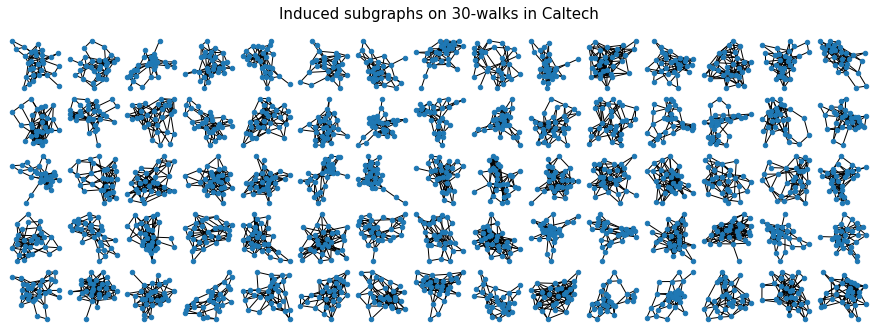

In [7]:
X, embs = G.get_patches(k=k, sample_size=250, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [8]:
def generate_nxg(get_patches_X):
    
    graph_list = []
    for i in range(X.shape[1]):
        adj_mat = X.T[i].reshape(30,30)
        G = nx.from_numpy_matrix(adj_mat)
        graph_list.append(G)
    
    return graph_list

def synchronization(colors):
    ordered = list(np.pi - colors); ordered.sort()
    lordered = len(ordered)
    
    threshold = np.pi
    if ordered == 0:
        assert("Empty array or logic error.")
    elif lordered == 1:
        return (0 < threshold)
    elif lordered == 2:
        dw = ordered[1]-ordered[0]
        if dw > threshold:
            return ((2*np.pi - dw) < threshold)
        else:
            return (dw < threshold)
    else:
        widths = [2*np.pi+ordered[0]-ordered[-1]]
        for i in range(lordered-1):
            widths.append(ordered[i+1]-ordered[i])
        return (np.abs(2*np.pi - max(widths)) < threshold)

In [9]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 250


In [10]:
nodes = int(np.sqrt(X.shape[0]))
r = 125
df = pd.DataFrame()
K = 2.5

for G in graph_list:
    
    headers = []
    for i in range(1, nodes+1):
        for j in range(1, r+1):
            headers.append(f's{i}_{j}')
        
    df1 = pd.DataFrame(columns=['# Edges', '# Nodes', 'Min Degree', 'Max Degree', 'Diameter', 'Synchronized'])
    temp = pd.DataFrame()
        
    if nx.is_connected(G):
        edges = G.number_of_edges()
        nodes = G.number_of_nodes()

        degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
        dmax = max(degree_sequence)
        dmin = min(degree_sequence)

        diam = nx.diameter(G)

        # Applying Kuramoto
        adj_mat = nx.to_numpy_array(G)
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, base_iter=r, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = synchronization(arr)
            
        df1.at[len(df1.index)] = [edges, nodes, dmin, dmax, diam, conc]

        df2 = pd.DataFrame(sim[:,:r].flatten(order='C')).T
        df2.columns = headers
            
        temp = pd.concat([df2, df1], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,s1_1,s1_2,s1_3,s1_4,s1_5,s1_6,s1_7,s1_8,s1_9,s1_10,...,s30_122,s30_123,s30_124,s30_125,# Edges,# Nodes,Min Degree,Max Degree,Diameter,Synchronized
0,0.003260,6.279740,6.273121,6.266587,6.260135,6.253764,6.247472,6.241256,6.235114,6.229043,...,3.679712,3.682020,3.684360,3.686732,85,30,1,10,5,False
1,0.040684,0.048713,0.056448,0.063883,0.071012,0.077830,0.084335,0.090522,0.096390,0.101936,...,2.197106,2.162870,2.128700,2.094597,89,30,1,12,5,False
2,2.650807,2.650625,2.650304,2.649848,2.649258,2.648538,2.647690,2.646716,2.645619,2.644401,...,1.631757,1.617095,1.602463,1.587865,97,30,1,13,4,True
3,4.881085,4.877420,4.873827,4.870307,4.866864,4.863500,4.860217,4.857019,4.853908,4.850886,...,1.768624,1.767156,1.765666,1.764155,100,30,2,12,4,True
4,3.564852,3.556129,3.546994,3.537430,3.527420,3.516943,3.505982,3.494514,3.482521,3.469981,...,0.149211,0.143410,0.137629,0.131867,79,30,1,13,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2.923044,2.938531,2.954112,2.969782,2.985536,3.001368,3.017273,3.033245,3.049279,3.065369,...,2.441124,2.431102,2.421116,2.411165,102,30,2,13,4,True
246,4.321986,4.331120,4.340225,4.349297,4.358331,4.367320,4.376261,4.385148,4.393975,4.402737,...,2.788504,2.788181,2.787840,2.787482,89,30,2,13,4,True
247,1.938923,1.941646,1.944577,1.947709,1.951031,1.954532,1.958201,1.962024,1.965987,1.970077,...,3.058516,3.070673,3.082792,3.094874,72,30,2,11,6,False
248,1.554530,1.562697,1.570925,1.579215,1.587570,1.595991,1.604482,1.613045,1.621682,1.630397,...,3.846565,3.850900,3.855159,3.859343,104,30,2,15,4,False


In [11]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.436


In [12]:
X, y = df.iloc[:, :-1], df.iloc[:, [-1]]
y = y.astype('int')

In [13]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

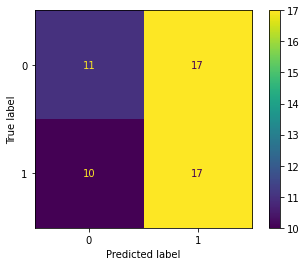

Precision: 0.500
Recall: 0.630
F1: 0.557
Accuracy: 0.509


In [15]:
clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

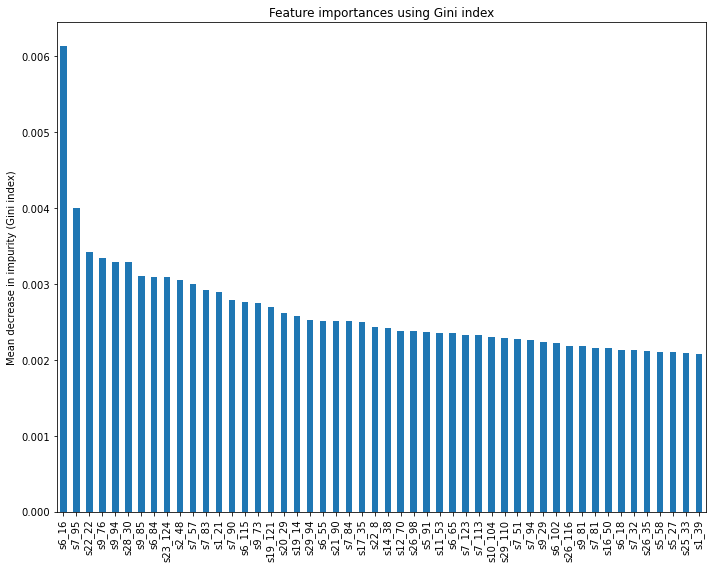

In [16]:
plot_gini_index(clf, X_train)

In [24]:
X_true = X_resampled[:100].values.astype('float32')
X_false = X_resampled[118:].values.astype('float32')

In [25]:
W_true, H_true = ALS(X = X_true, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 100, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 100, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

 40%|██████████████                     | 40/100 [00:00<00:00, 204.23it/s]

iteration 0, reconstruction error 5543624.118546
iteration 10, reconstruction error 1587783.497629
iteration 20, reconstruction error 1289227.260931
iteration 30, reconstruction error 917501.802945
iteration 40, reconstruction error 838628.814299


 83%|█████████████████████████████      | 83/100 [00:00<00:00, 203.11it/s]

iteration 50, reconstruction error 810214.650154
iteration 60, reconstruction error 797735.612180
iteration 70, reconstruction error 791174.536111
iteration 80, reconstruction error 786746.029399
iteration 90, reconstruction error 783183.026283


100%|██████████████████████████████████| 100/100 [00:00<00:00, 199.39it/s]




###########################
Shape of W_true: (100, 9)
###########################




 15%|█████▎                             | 15/100 [00:00<00:00, 140.31it/s]

iteration 0, reconstruction error 5529376.723449
iteration 10, reconstruction error 1524023.004895
iteration 20, reconstruction error 1216574.188912
iteration 30, reconstruction error 878128.139117


 80%|████████████████████████████       | 80/100 [00:00<00:00, 210.59it/s]

iteration 40, reconstruction error 804852.615348
iteration 50, reconstruction error 776344.035689
iteration 60, reconstruction error 762932.175854
iteration 70, reconstruction error 755172.419535
iteration 80, reconstruction error 749894.411211


100%|██████████████████████████████████| 100/100 [00:00<00:00, 181.37it/s]

iteration 90, reconstruction error 745898.922411


###########################
Shape of W_false: (100, 9)
###########################




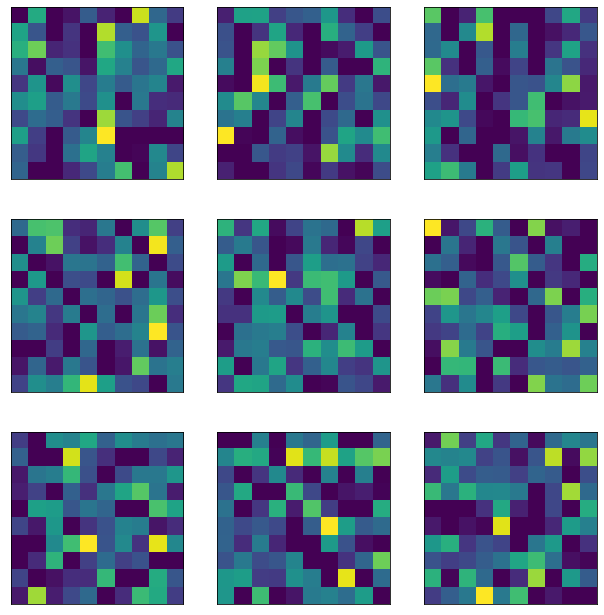

In [26]:
display_dictionary(W_true, dictionary_shape=(10, 10), save_name="images/dict_caltech30walk_dynamics_sync", figsize=[10,10])

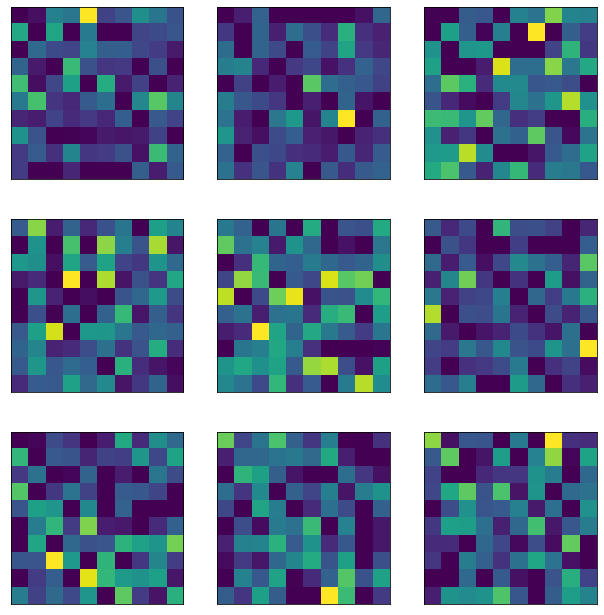

In [27]:
display_dictionary(W_false, dictionary_shape=(10, 10), save_name="images/dict_caltech30walk_dynamics_nonsync", figsize=[10,10])